In [ ]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch, BicScore
import bnlearn as bn
import numpy as np
import json
from collections import defaultdict

data = pd.read_csv('C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv')

data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1)

In [2]:
sample = data.sample(n=9600, random_state=42)

In [3]:
model = bn.structure_learning.fit(data, methodtype='hc', scoretype='bic')

# Print out the learned edges
print("Learned network structure (edges):", model['model_edges'])

# Visualize the network
# bn.plot_graphviz(model)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
Learned network structure (edges): [('Num_of_Delayed_Payment', 'Credit_Mix'), ('Credit_Mix', 'Interest_Rate'), ('Credit_Mix', 'Num_Bank_Accounts'), ('Credit_Mix', 'Payment_of_Min_Amount'), ('Credit_Mix', 'Delay_from_due_date'), ('Credit_Mix', 'Num_of_Loan'), ('Credit_Mix', 'Num_Credit_Inquiries'), ('Credit_Mix', 'Num_Credit_Card'), ('Credit_Mix', 'Credit_History_Age'), ('Credit_Mix', 'Age'), ('Credit_Mix', 'Payment_Behaviour'), ('Payment_of_Min_Amount', 'Num_Credit_Inquiries'), ('Payment_of_Min_Amount', 'Num_of_Loan')]


[setgraphviz] >INFO> System found: windows
[setgraphviz] >INFO> Set Graphviz path in environment.


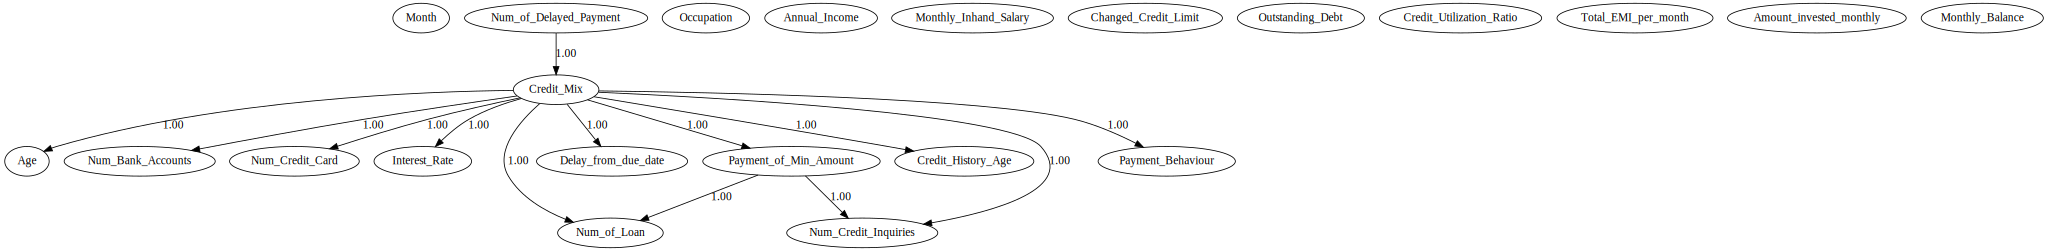

In [4]:
bn.plot_graphviz(model)

In [ ]:
def generate_generation_profile(df, categorical_cols, bn_edges):
    """
    Generates a generation profile from data and a Bayesian network structure.
    
    Parameters:
        df (pd.DataFrame): The original dataset.
        categorical_cols (list): List of column names that are categorical.
        bn_edges (list of tuples): BN structure as (parent, child) edges.
    
    Returns:
        dict: Generation profile containing marginal and conditional parameters.
    """
    # List all variables and deduce numerical columns
    all_vars = list(df.columns)
    numerical_cols = [col for col in all_vars if col not in categorical_cols]

    profile = {"variables": {}, "structure": bn_edges}
    
    # Compute marginal distributions or parameters for each variable.
    for col in all_vars:
        if col in categorical_cols:
            # Compute marginal probabilities for categorical variable.
            marginal = df[col].value_counts(normalize=True).to_dict()
            levels = list(marginal.keys())
            profile["variables"][col] = {
                "type": "categorical",
                "levels": levels,
                "marginal": marginal
            }
        else:
            # For numerical variables, assume a Gaussian distribution.
            mean_val = df[col].mean()
            std_val = df[col].std()
            profile["variables"][col] = {
                "type": "numerical",
                "distribution": "Gaussian",
                "parameters": {"mean": mean_val, "std": std_val}
            }
    
    # Build a dictionary mapping each child to its parent(s) from the BN edges.
    parent_dict = defaultdict(list)
    for parent, child in bn_edges:
        parent_dict[child].append(parent)
    
    # For each variable that has parents, compute the conditional distribution.
    for child, parents in parent_dict.items():
        # Ensure the child is in the dataset.
        if child not in df.columns:
            continue
        # Group the data by the parent variables.
        grouped = df.groupby(parents)
        cond_table = {}
        for group_vals, group_df in grouped:
            # Format the parent's configuration as a string key.
            if not isinstance(group_vals, tuple):
                config_key = f"{parents[0]}={group_vals}"
            else:
                config_key = ",".join([f"{p}={v}" for p, v in zip(parents, group_vals)])
            
            if child in categorical_cols:
                # Compute conditional probabilities for categorical child.
                cond_prob = group_df[child].value_counts(normalize=True).to_dict()
                cond_table[config_key] = cond_prob
            else:
                # For numerical child, compute mean and std conditional on the parent's config.
                mean_val = group_df[child].mean()
                std_val = group_df[child].std()
                cond_table[config_key] = {"mean": mean_val, "std": std_val}
        
        # Save the conditional information in the profile.
        profile["variables"][child]["conditional"] = {
            "parents": parents,
            "table": cond_table
        }
    
    return profile

# Example usage:
# Assume you have a DataFrame 'df' with your dataset.
# Define your categorical columns and the learned BN edges:
categorical_cols = ['Month','Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
bn_edges = [
    ('Num_of_Delayed_Payment', 'Credit_Mix'), 
    ('Credit_Mix', 'Interest_Rate'), 
    ('Credit_Mix', 'Num_Bank_Accounts'), 
    ('Credit_Mix', 'Payment_of_Min_Amount'), 
    ('Credit_Mix', 'Delay_from_due_date'), 
    ('Credit_Mix', 'Num_of_Loan'), 
    ('Credit_Mix', 'Num_Credit_Inquiries'), 
    ('Credit_Mix', 'Num_Credit_Card'), 
    ('Credit_Mix', 'Credit_History_Age'), 
    ('Credit_Mix', 'Age'), 
    ('Credit_Mix', 'Payment_Behaviour'), 
    ('Payment_of_Min_Amount', 'Num_Credit_Inquiries'), 
    ('Payment_of_Min_Amount', 'Num_of_Loan')
]

# Generate the profile.
profile = generate_generation_profile(data, categorical_cols, bn_edges)

# Output the profile as a JSON formatted string.
print(json.dumps(profile, indent=4, default=lambda x: float(x)))


{
    "variables": {
        "Month": {
            "type": "categorical",
            "levels": [
                "September",
                "November",
                "December",
                "October"
            ],
            "marginal": {
                "September": 0.2529835055820427,
                "November": 0.2506736948088484,
                "December": 0.2501110485948651,
                "October": 0.24623175101424383
            }
        },
        "Age": {
            "type": "numerical",
            "distribution": "Gaussian",
            "parameters": {
                "mean": 33.85303088631585,
                "std": 10.345456801704989
            },
            "conditional": {
                "parents": [
                    "Credit_Mix"
                ],
                "table": {
                    "Credit_Mix=Bad": {
                        "mean": 30.433391434262948,
                        "std": 8.816989607707047
                    },
             

# Alternative Package for BN

In [ ]:
# Create a HillClimbSearch instance using only the data
hc = HillClimbSearch(sample)

# Now pass the scoring_method to the estimate() function
best_model = hc.estimate(scoring_method=BicScore(sample), max_indegree=3)

print("Learned network structure (edges):", best_model.edges())